In [1]:
import torch
import torch.nn as nn
from torch import optim
from torch.autograd import Variable

import os
import glob
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import librosa # librosa: Audio handling package
import random
import copy
import re
import jamotools

from tqdm import tqdm_notebook as tqdm # tqdm: Pakage for progress bar visualization
from datetime import datetime

import threading
import queue

import Levenshtein as Lev

In [2]:
n_mels = 80
fs = 16000
frame_length_ms=50
frame_shift_ms=25
nsc = int(fs * frame_length_ms / 1000)
nov = nsc - int(fs * frame_shift_ms / 1000)
nhop = int(fs * frame_shift_ms / 1000)
eps = 1e-8
db_ref = 160

# meta_path = 'gdrive/My Drive/korean-single-speaker-speech-dataset/transcript.v.1.2.txt'
# data_folder = 'gdrive/My Drive/korean-single-speaker-speech-dataset/kss'

# meta_path = "D:/korean-single-speaker-speech-dataset/transcript.v.1.2.txt"
# data_folder = "D:/korean-single-speaker-speech-dataset/kss"

data_folder = "D:/nsml-dataset/train_data/"
label_path = "D:/nsml-dataset/hackathon.labels"

data_list = glob.glob(data_folder + '*.csv')[0]

wav_paths = list()
script_paths = list()
korean_script_paths = list()

with open(data_list, 'r') as f:
    for line in f:
        # line: "aaa.wav,aaa.label"
        wav_path, script_path = line.strip().split(',')
        korean_script_path = script_path.replace('.label', '.script')
        
        wav_paths.append(os.path.join(data_folder, wav_path))
        script_paths.append(os.path.join(data_folder, script_path))
        korean_script_paths.append(os.path.join(data_folder, korean_script_path))

dataset_size = len(wav_paths)

In [3]:
def get_label(filepath, bos_id, eos_id):
    key = filepath.split('/')[-1].split('.')[0]
    script = target_dict[key]
    tokens = script.split(' ')
    result = list()
    result.append(bos_id)
    for i in range(len(tokens)):
        if len(tokens[i]) > 0:
            result.append(int(tokens[i]))
    result.append(eos_id)
    return result

In [4]:
print("wav_paths len: {}".format(len(wav_paths)))
print("script_paths len: {}".format(len(script_paths)))
print("korean_script_paths len: {}".format(len(korean_script_paths)))

print(wav_paths[0])
print(script_paths[0])
print(korean_script_paths[0])

wav_paths len: 29805
script_paths len: 29805
korean_script_paths len: 29805
D:/nsml-dataset/train_data/41_0601_211_0_07930_02.wav
D:/nsml-dataset/train_data/41_0601_211_0_07930_02.label
D:/nsml-dataset/train_data/41_0601_211_0_07930_02.script


In [64]:
def find_starting_point(coef, thres = 0.1, margin = 10):
    starting_point = 0
    for i in range(len(coef) - 1):
        if (coef[i] <= thres and coef[i+1] > thres):
            starting_point = i
            break
            
    starting_point = starting_point - margin
    
    if starting_point < 0:
        starting_point = 0
    
    return starting_point

def find_ending_point(coef, thres = 0.1, margin = 10):
    for i in range(len(coef) - 1, 0, -1):
        if (coef[i] <= thres and coef[i-1] > thres):
            ending_point = i
            break
            
    print(ending_point)
            
    ending_point = ending_point + margin
    
    if ending_point > len(coef):
        ending_point = len(coef)

    return ending_point

In [65]:
count = 0

272
272
272
94
94
94
141
141
141
497
497
497
184
184
184
105
105
105
138
138
138
79
79
79
175
175
175
95
95
95
94
94
94
115
115
115
102
102
102
93
93
93
79
79
79
319
319
319
168
168
168
102
102
102
137
137
137
166
166
166
78


C:\Users\JW\AppData\Local\Continuum\anaconda3\envs\pytorch_env\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':


78
78
150
150
150
165
165
165
150
150
150
189
189
189
142
142
142
193
193
193
111
111
111
192
192
192
135
135
135
120
120
120
118
118
118
89
89
89
129
129
129
91
91
91
107
107
107
337
337
337
104
104
104
149
149
149
139
139
139
111
111
111
103
103
103
138
138
138
138
138
138
96
96
96
169
169
169
221
221
221
77
77
77
105
105
105
206
206
206
104
104
104
114
114
114
164
164
164
187
187
187
131
131
131
120
120
120
109
109
109
134
134
134
276
276
276
131
131
131
589
589
589
125
125
125
137
137
137
238
238
238
123
123
123
143
143
143
120
120
120
162
162
162
186
186
186
118
118
118
463
463
463
298
298
298
97
97
97
208
208
208
127
127
127
135
135
135
161
161
161
164
164
164
128
128
128
159
159
159
86
86
86
374
374
374
85
85
85
163
163
163
170
170
170
128
128
128
83
83
83
125
125
125
104
104
104
353
353
353
131
131
131
130
130
130
135
135
135
127
127
127
134
134
134
257
257
257
80
80
80
120
120
120
175
175
175
120
120
120


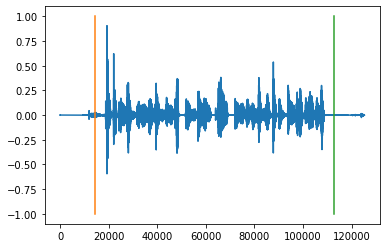

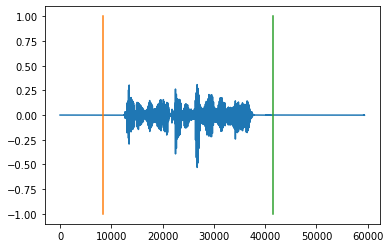

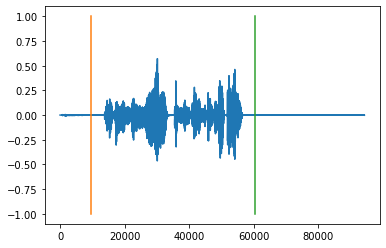

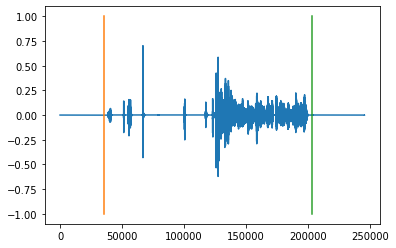

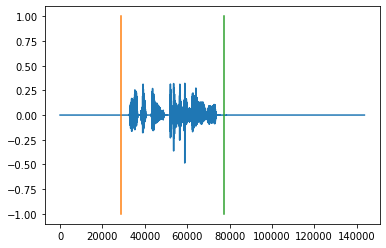

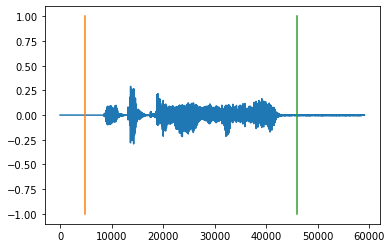

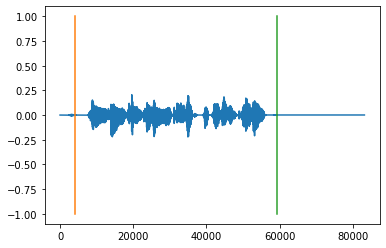

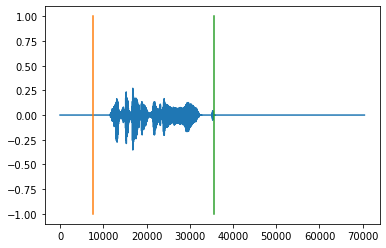

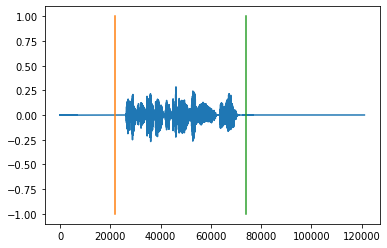

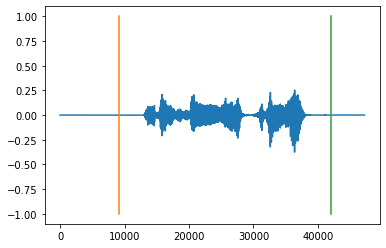

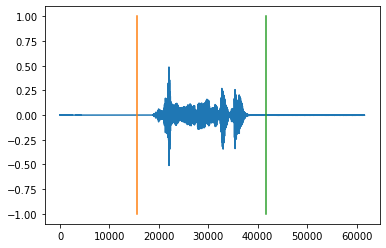

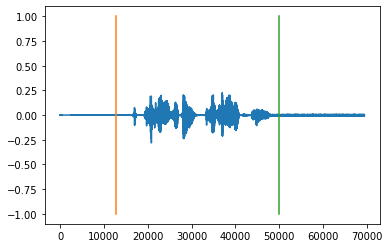

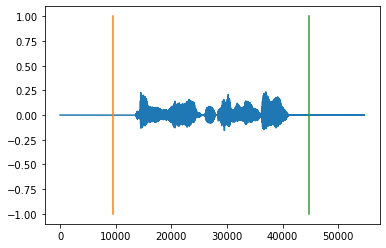

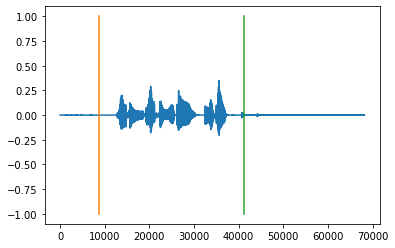

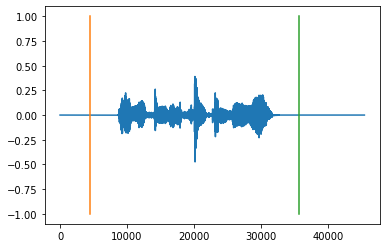

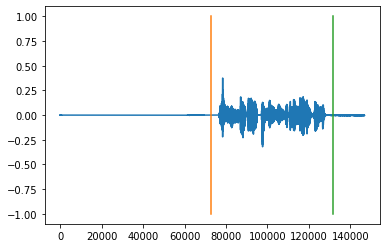

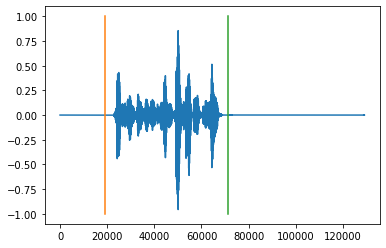

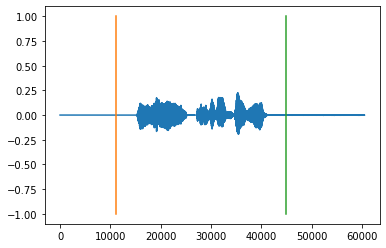

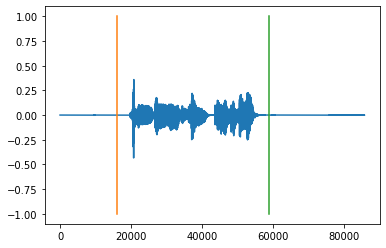

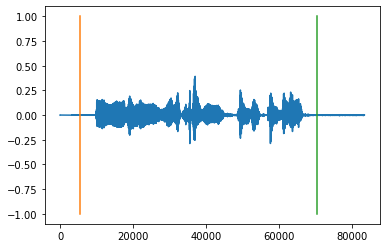

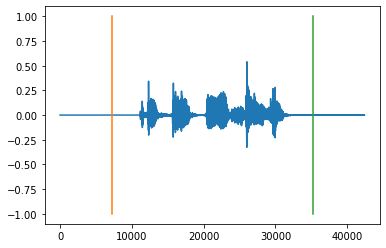

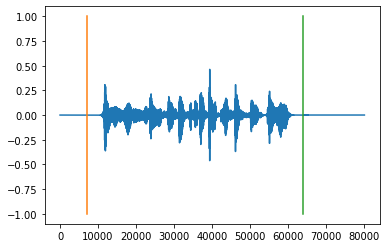

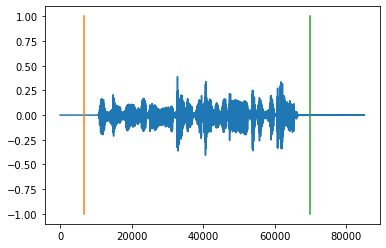

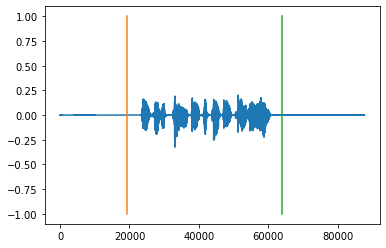

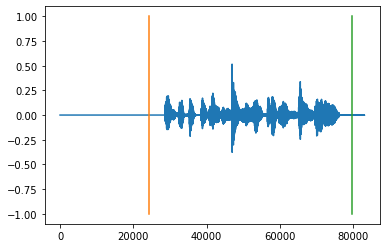

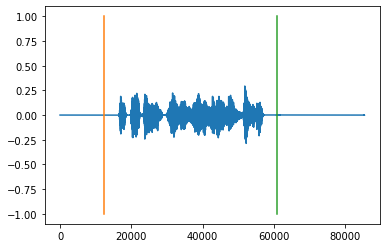

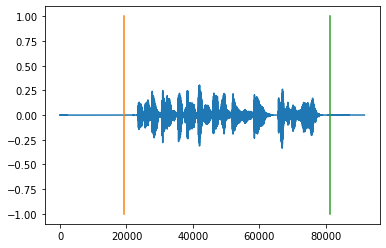

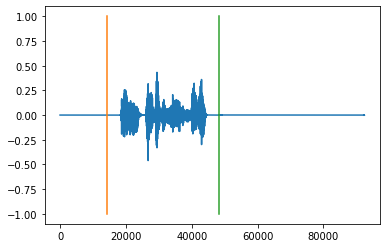

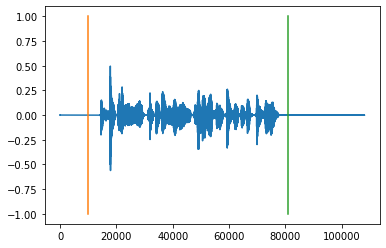

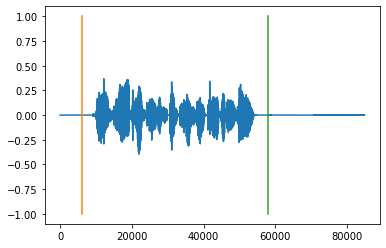

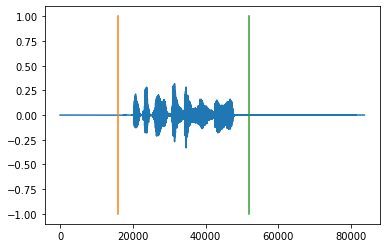

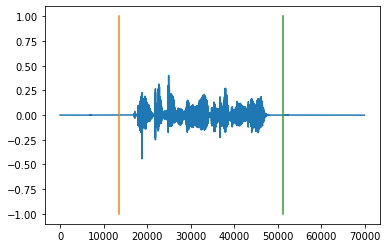

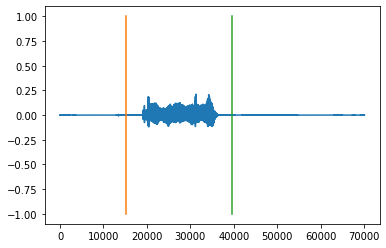

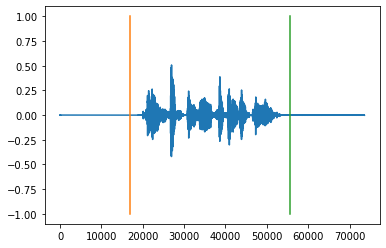

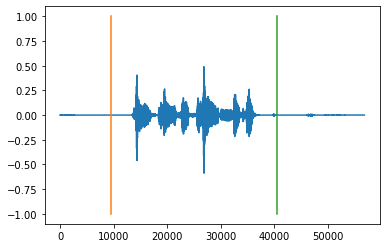

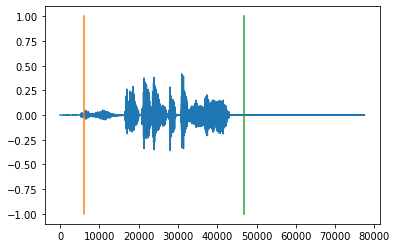

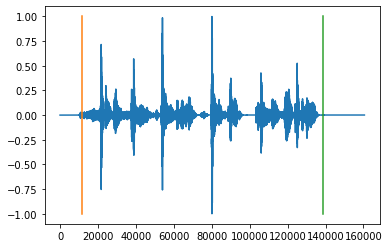

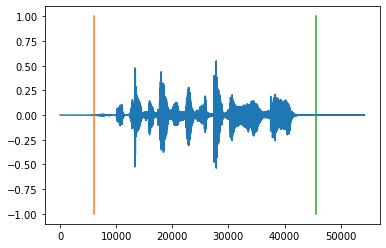

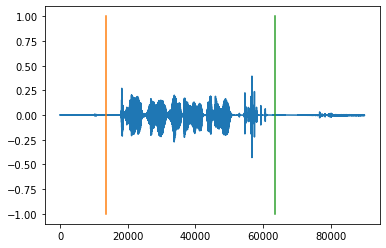

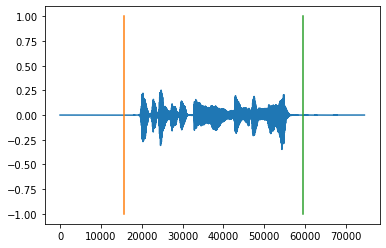

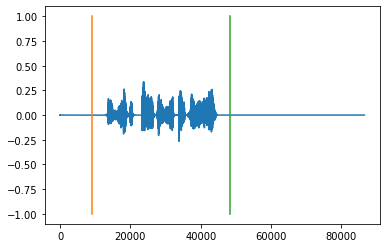

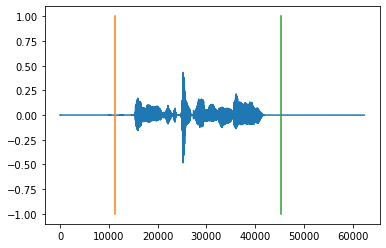

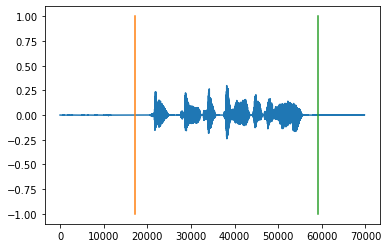

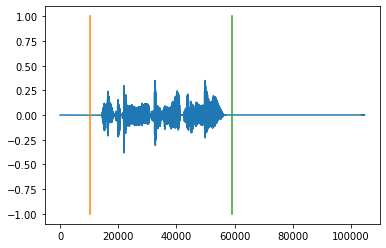

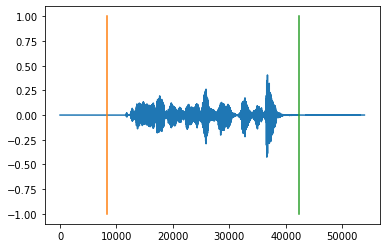

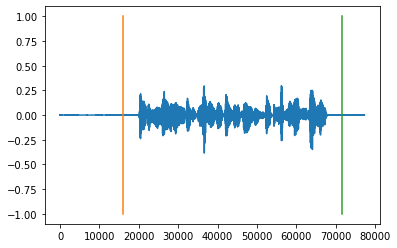

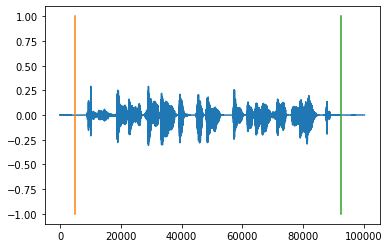

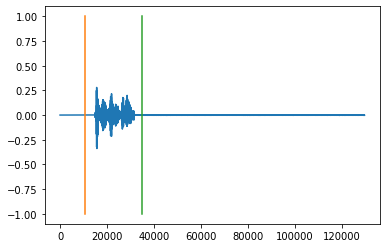

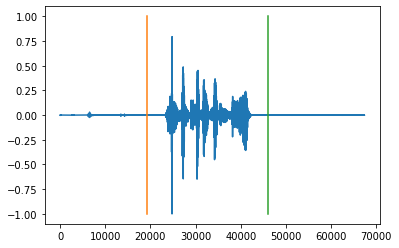

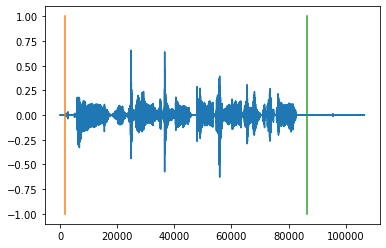

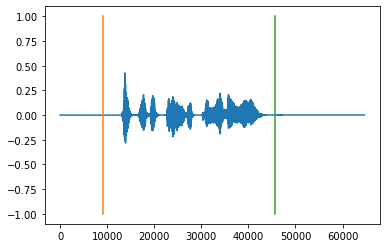

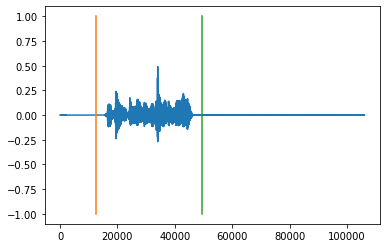

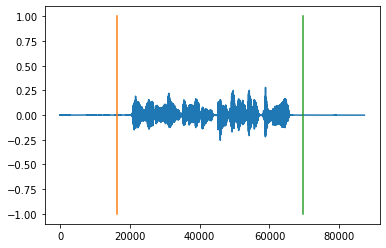

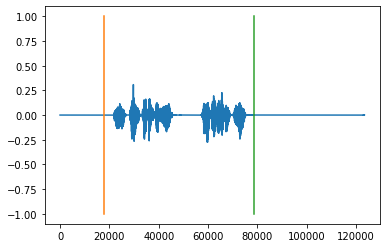

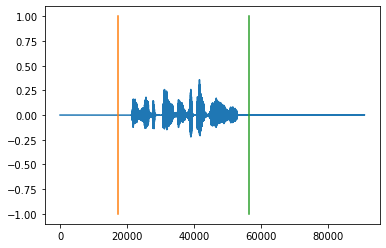

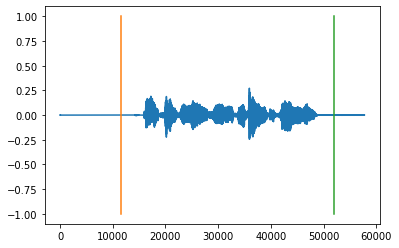

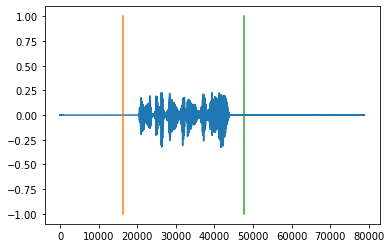

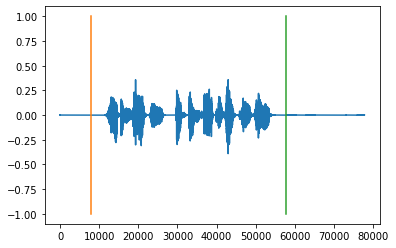

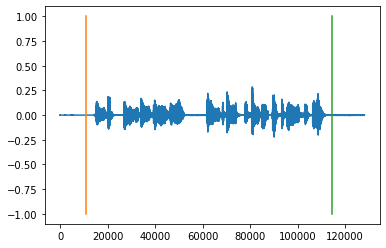

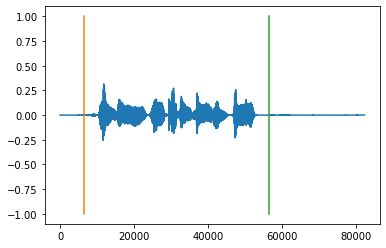

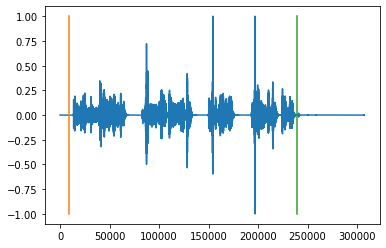

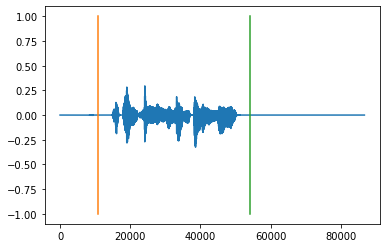

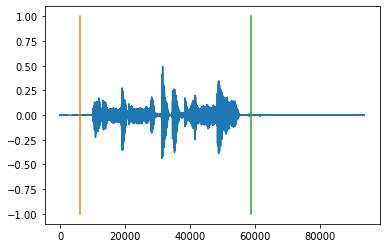

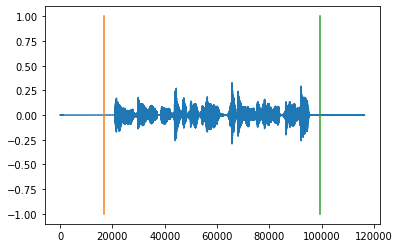

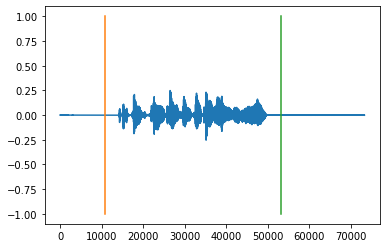

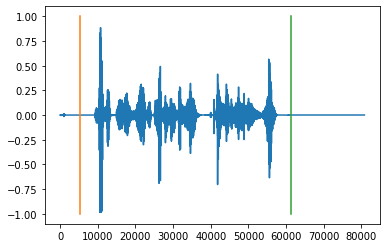

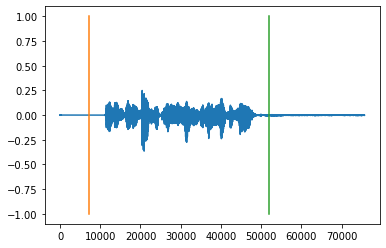

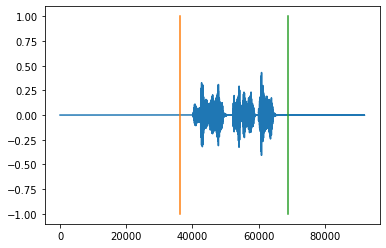

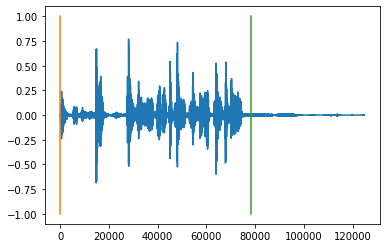

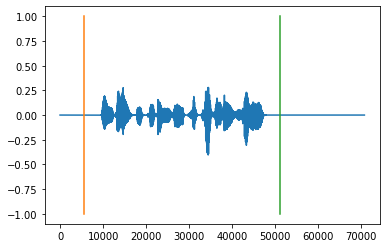

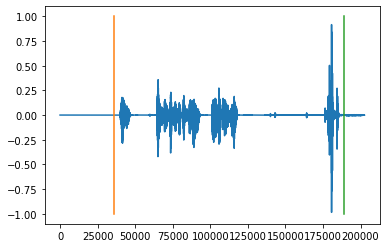

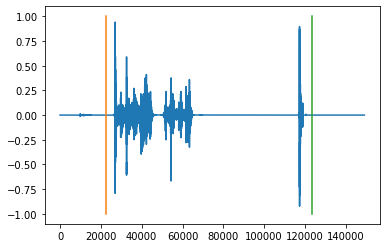

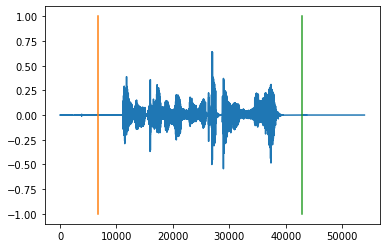

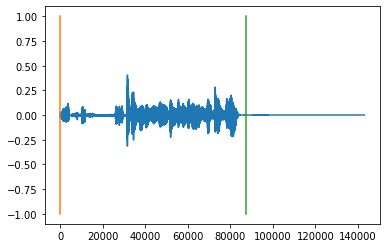

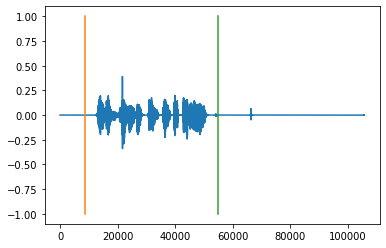

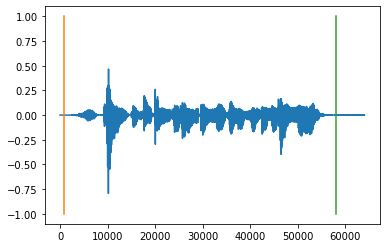

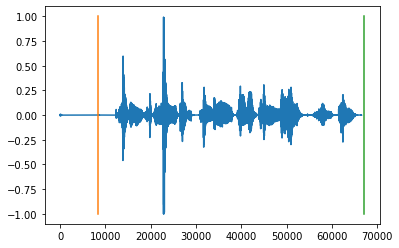

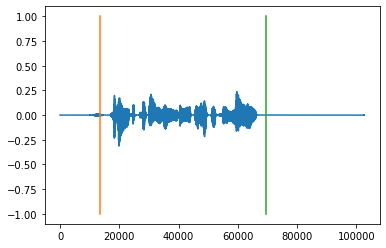

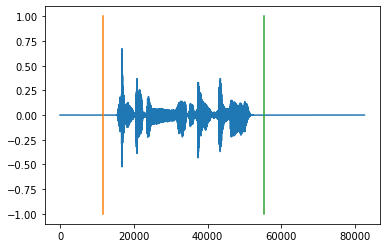

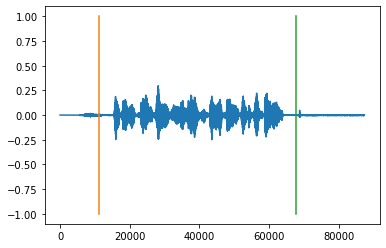

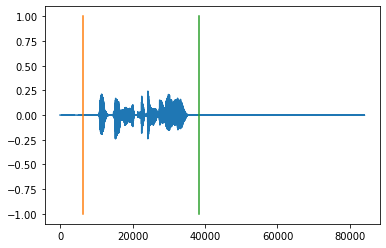

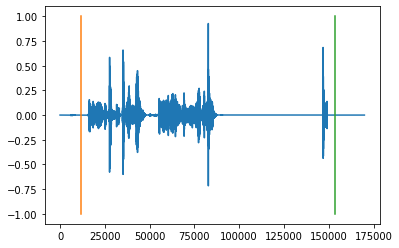

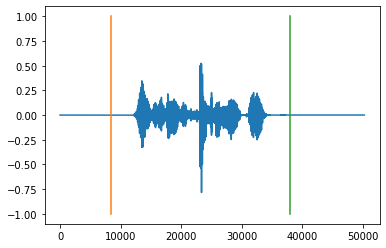

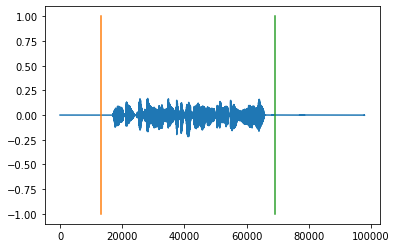

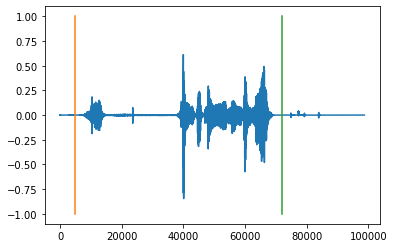

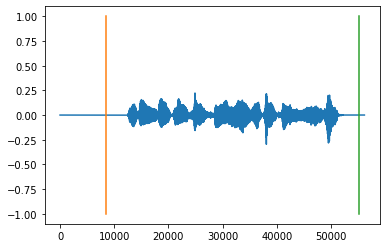

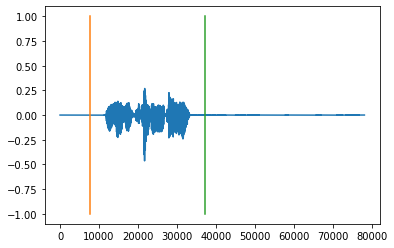

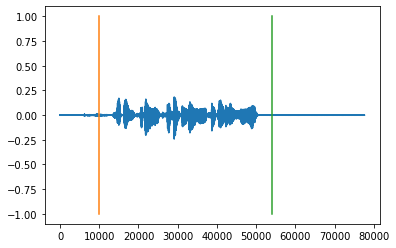

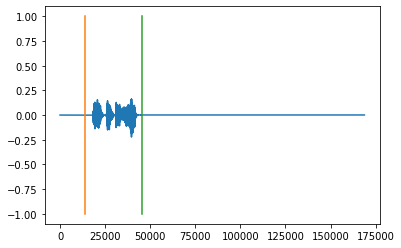

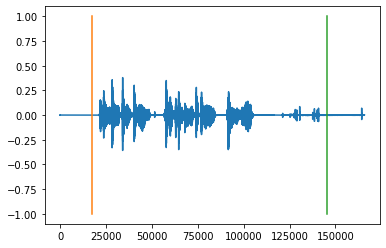

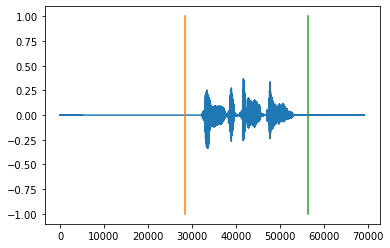

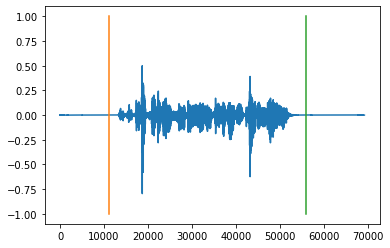

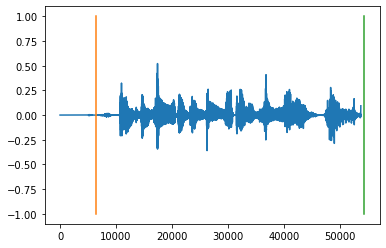

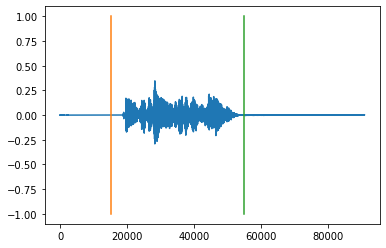

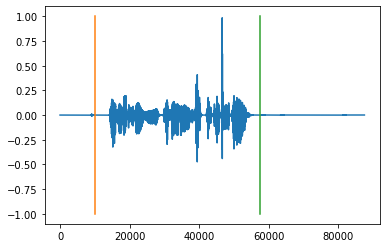

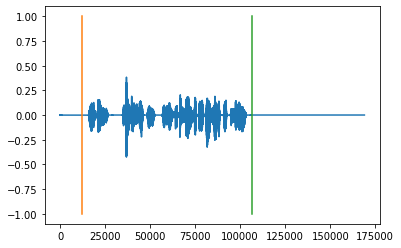

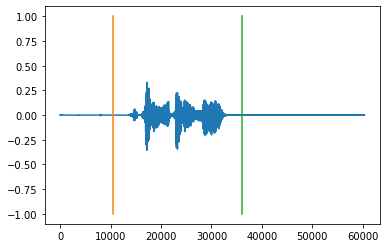

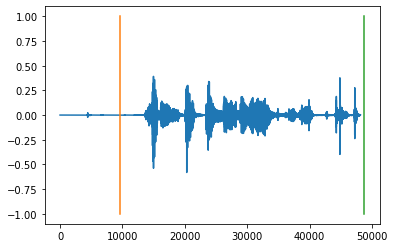

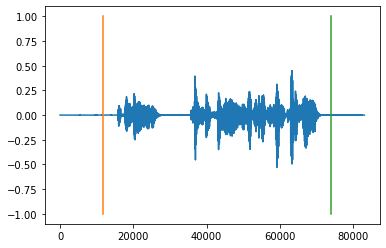

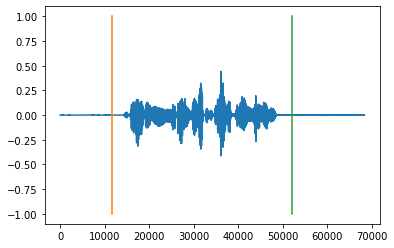

In [67]:
for wav_path in wav_paths[count:]:
    y, fs = librosa.load(wav_path, sr=16000)
    f, t, Zxx = sp.signal.stft(y, fs=16000, nperseg=nsc, noverlap=nov)
    Sxx = np.abs(Zxx)
    
    coef = np.sum(Sxx, 0)
    Sxx = Sxx[:, find_starting_point(coef):find_ending_point(coef)]
    
    plt.figure()
    plt.plot(y)
    plt.plot([find_starting_point(coef) * nov, find_starting_point(coef) * nov], [-1, 1])
    plt.plot([find_ending_point(coef) * nov, find_ending_point(coef) * nov], [-1, 1])

    count = count + 1
    
    if (count % 100 == 0):
        break